In [11]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm, wilcoxon
import pulp
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('bmh')

# Simulate longitudinal data for 400 patients
np.random.seed(42)
n_patients = 400
time_points = np.arange(0, 25, 3)  # 0-24 months in 3-month intervals

# Generate patient data
patients = []
for pid in range(n_patients):
    base_pain = np.random.randint(0, 10)
    base_urgency = np.random.randint(0, 10)
    base_freq = np.random.randint(0, 10)
    
    # Simulate time-varying symptoms with autoregressive process
    pain = [base_pain + np.random.randint(-1, 2)]
    urgency = [base_urgency + np.random.randint(-1, 2)]
    freq = [base_freq + np.random.randint(-1, 2)]
    for t in range(1, len(time_points)):
        pain.append(pain[-1] + np.random.randint(-1, 2))
        urgency.append(urgency[-1] + np.random.randint(-1, 2))
        freq.append(freq[-1] + np.random.randint(-1, 2))
    
    # Clip to 0-9 scale
    pain = np.clip(pain, 0, 9)
    urgency = np.clip(urgency, 0, 9)
    freq = np.clip(freq, 0, 9)
    
    # Treatment assignment (hazard increases with recent symptom worsening)
    treat_prob = 0.1 + 0.05*(np.mean(pain[-2:]) > 5)  # Simplified model
    treated = np.random.binomial(1, treat_prob)
    treat_time = np.random.choice(time_points[1:-1]) if treated else np.inf
    
    patients.append({
        'id': pid,
        'treated': treated,
        'treat_time': treat_time,
        'base_pain': base_pain,
        'base_urgency': base_urgency,
        'base_freq': base_freq,
        'time_pain': pain,
        'time_urgency': urgency,
        'time_freq': freq,
    })

df = pd.DataFrame(patients)

def calculate_trimean(values):
    """Calculate trimean (average of median and two quartiles)"""
    q1, median, q3 = np.percentile(values, [25, 50, 75])
    return (q1 + 2*median + q3) / 4

def analyze_matching_quality(df, matched_pairs, covariates):
    """Analyze and report matching quality metrics"""
    distances_before = []
    distances_after = []
    
    # Calculate Mahalanobis distances before and after matching
    cov_matrix = np.cov(df[covariates].values.T)
    treated = df[df['treated'] == 1]
    control = df[df['treated'] == 0]
    
    # Before matching distances
    for _, t_row in treated.iterrows():
        for _, c_row in control.iterrows():
            dist = calculate_mahalanobis(
                t_row[covariates].values, 
                c_row[covariates].values, 
                cov_matrix
            )
            distances_before.append(dist)
    
    # After matching distances
    for t, c in matched_pairs:
        t_row = df.loc[df['id'] == t, covariates].values[0]
        c_row = df.loc[df['id'] == c, covariates].values[0]
        dist = calculate_mahalanobis(t_row, c_row, cov_matrix)
        distances_after.append(dist)
    
    # Calculate statistics
    stats_before = {
        'median': np.median(distances_before),
        'q3': np.percentile(distances_before, 75),
        'max': np.max(distances_before)
    }
    
    stats_after = {
        'median': np.median(distances_after),
        'q3': np.percentile(distances_after, 75),
        'max': np.max(distances_after)
    }
    
    return stats_before, stats_after

In [12]:
df.head()

,id,treated,treat_time,base_pain,base_urgency,base_freq,time_pain,time_urgency,time_freq
0,0,0,inf,6,3,7,"[5, 5, 6, 7, 7, 7, 7, 6, 7]","[2, 3, 4, 4, 4, 3, 3, 2, 3]","[8, 9, 8, 7, 7, 6, 5, 6, 6]"
1,1,0,inf,2,6,3,"[1, 2, 1, 0, 0, 0, 0, 1, 1]","[7, 8, 9, 9, 8, 8, 7, 7, 7]","[2, 1, 1, 1, 1, 2, 3, 2, 2]"
2,2,0,inf,9,3,5,"[8, 8, 8, 9, 8, 7, 6, 5, 6]","[4, 4, 4, 4, 4, 4, 4, 3, 2]","[5, 5, 6, 7, 6, 7, 6, 5, 4]"
3,3,0,inf,8,7,0,"[9, 8, 7, 7, 6, 6, 7, 8, 9]","[8, 9, 9, 9, 9, 9, 9, 9, 9]","[1, 2, 1, 1, 0, 1, 0, 1, 2]"
4,4,0,inf,2,0,4,"[2, 2, 1, 1, 2, 1, 0, 0, 0]","[1, 2, 3, 3, 4, 3, 4, 5, 4]","[5, 6, 7, 6, 7, 7, 8, 9, 9]"


In [13]:
df['treat_time'].value_counts()

treat_time
inf     347
3.0      11
6.0      10
21.0      9
18.0      7
12.0      6
15.0      5
9.0       5
Name: count, dtype: int64

In [14]:
# Extract latest values from time series (get the last element of each list)
df['time_pain_latest'] = df['time_pain'].apply(lambda x: x[-1])
df['time_urgency_latest'] = df['time_urgency'].apply(lambda x: x[-1])
df['time_freq_latest'] = df['time_freq'].apply(lambda x: x[-1])

In [15]:
df.head()

,id,treated,treat_time,base_pain,base_urgency,base_freq,time_pain,time_urgency,time_freq,time_pain_latest,time_urgency_latest,time_freq_latest
0,0,0,inf,6,3,7,"[5, 5, 6, 7, 7, 7, 7, 6, 7]","[2, 3, 4, 4, 4, 3, 3, 2, 3]","[8, 9, 8, 7, 7, 6, 5, 6, 6]",7,3,6
1,1,0,inf,2,6,3,"[1, 2, 1, 0, 0, 0, 0, 1, 1]","[7, 8, 9, 9, 8, 8, 7, 7, 7]","[2, 1, 1, 1, 1, 2, 3, 2, 2]",1,7,2
2,2,0,inf,9,3,5,"[8, 8, 8, 9, 8, 7, 6, 5, 6]","[4, 4, 4, 4, 4, 4, 4, 3, 2]","[5, 5, 6, 7, 6, 7, 6, 5, 4]",6,2,4
3,3,0,inf,8,7,0,"[9, 8, 7, 7, 6, 6, 7, 8, 9]","[8, 9, 9, 9, 9, 9, 9, 9, 9]","[1, 2, 1, 1, 0, 1, 0, 1, 2]",9,9,2
4,4,0,inf,2,0,4,"[2, 2, 1, 1, 2, 1, 0, 0, 0]","[1, 2, 3, 3, 4, 3, 4, 5, 4]","[5, 6, 7, 6, 7, 7, 8, 9, 9]",0,4,9


In [16]:
df.dtypes

id                       int64
treated                  int64
treat_time             float64
base_pain                int64
base_urgency             int64
base_freq                int64
time_pain               object
time_urgency            object
time_freq               object
time_pain_latest         int64
time_urgency_latest      int64
time_freq_latest         int64
dtype: object

In [17]:
def calculate_mahalanobis(treated_vec, control_vec, cov_matrix):
    diff = treated_vec - control_vec
    inv_cov = np.linalg.pinv(cov_matrix)  # Use pseudoinverse for stability
    return np.sqrt(diff.dot(inv_cov).dot(diff))

def create_tertile_indicators(df, column):
    # Make sure we're working with numeric values
    values = pd.to_numeric(df[column])
    tertiles = np.percentile(values, [33.33, 66.67])
    
    df[f'{column}_low'] = (values <= tertiles[0]).astype(int)
    df[f'{column}_med'] = ((values > tertiles[0]) & (values <= tertiles[1])).astype(int)
    df[f'{column}_high'] = (values > tertiles[1]).astype(int)
    return df

def get_eligible_controls(treated_time, control_df):
    return control_df[
        (control_df['treat_time'] > treated_time) | 
        (control_df['treat_time'].isna())
    ]

def balanced_risk_set_matching(df):
    # Make a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Step 2: Define covariates to balance - use the _latest columns
    covariates = ['base_pain', 'base_urgency', 'base_freq', 
                  'time_pain_latest', 'time_urgency_latest', 'time_freq_latest']
    
    # Step 3: Apply tertile indicators
    for col in covariates:
        df = create_tertile_indicators(df, col)
    
    # Step 4: Create treated and control groups
    treated = df[df['treated'] == 1].sort_values('treat_time')
    controls = df[df['treated'] == 0].copy()
    
    # Step 5: Create edges for potential matches
    edges = []
    for _, t_row in treated.iterrows():
        t_time = t_row['treat_time']
        eligible_controls = get_eligible_controls(t_time, controls)
        for _, c_row in eligible_controls.iterrows():
            edges.append((t_row['id'], c_row['id']))
    
    # Step 6: Calculate Mahalanobis distances
    covariates_matrix = df[covariates].values
    cov_matrix = np.cov(covariates_matrix.T)
    distances = {}
    for (t, c) in edges:
        t_vec = df.loc[df['id'] == t, covariates].values.ravel()
        c_vec = df.loc[df['id'] == c, covariates].values.ravel()
        distances[(t, c)] = calculate_mahalanobis(t_vec, c_vec, cov_matrix)
    
    # Step 7: Setup optimization problem
    prob = pulp.LpProblem("BalancedMatching", pulp.LpMinimize)
    x = pulp.LpVariable.dicts("pair", edges, cat='Binary')
    
    # Step 8: Add objective
    prob += pulp.lpSum([distances[e] * x[e] for e in edges])
    
    # Step 9: Add one-to-one matching constraints
    control_ids = controls['id'].unique()
    for t in treated['id']:
        prob += pulp.lpSum([x[(t, c)] for c in control_ids if (t,c) in edges]) == 1
    
    for c in control_ids:
        prob += pulp.lpSum([x[(t, c)] for t in treated['id'] if (t,c) in edges]) <= 1
    
    # Step 10: Add balance constraints
    balance_vars = [col for col in df.columns if ('_low' in col or '_med' in col or '_high' in col)]
    for col in balance_vars:
        treated_total = df[df['treated'] == 1][col].sum()
        control_expr = pulp.lpSum([df.loc[df['id'] == c, col].values[0] * x[(t, c)] 
                                 for (t, c) in edges])
        prob += control_expr == treated_total
    
    # Step 11: Solve the optimization problem
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Step 12: Extract matched pairs
    matched_pairs = []
    for (t, c) in edges:
        if x[(t, c)].value() > 0.5:
            matched_pairs.append((t, c))
    
    return matched_pairs

def sensitivity_analysis(matched_pairs, df, outcome_col, gamma_values=None):
    """Modified sensitivity analysis to match paper's gamma values"""
    if gamma_values is None:
        gamma_values = [1.1, 1.4, 2.0, 2.5, 3.0]  # default values from the paper
        
    results = []
    
    for gamma in gamma_values:
        treated_outcomes = []
        control_outcomes = []
        
        for t, c in matched_pairs:
            treated_outcomes.append(df.loc[df['id'] == t, outcome_col].values[0])
            control_outcomes.append(df.loc[df['id'] == c, outcome_col].values[0])
        
        # Calculate trimeans
        treated_trimean = calculate_trimean(treated_outcomes)
        control_trimean = calculate_trimean(control_outcomes)
        contrast = treated_trimean - control_trimean
        
        # Wilcoxon test
        stat, p_value = wilcoxon(treated_outcomes, control_outcomes)
        
        results.append({
            'gamma': gamma,
            'treated_trimean': treated_trimean,
            'control_trimean': control_trimean,
            'contrast': contrast,
            'p_value': p_value
        })
    
    return pd.DataFrame(results)

In [18]:
def check_balance_statistics(df, matched_pairs):
    """Check balance of tertiles between treated and control groups"""
    treated_ids = [p[0] for p in matched_pairs]
    control_ids = [p[1] for p in matched_pairs]
    
    variables = ['base_pain', 'base_urgency', 'base_freq',
                'time_pain_latest', 'time_urgency_latest', 'time_freq_latest']
    
    balance_stats = {}
    for var in variables:
        treated_values = df.loc[treated_ids, var]
        control_values = df.loc[control_ids, var]
        
        # Calculate tertiles
        tertiles = np.percentile(df[var], [33.33, 66.67])
        
        # Calculate percentages below first tertile
        treated_below = (treated_values <= tertiles[0]).mean() * 100
        control_below = (control_values <= tertiles[0]).mean() * 100
        
        balance_stats[var] = {
            'treated_below_tertile1': treated_below,
            'control_below_tertile1': control_below,
            'tertile1': tertiles[0],
            'tertile2': tertiles[1]
        }
    
    return balance_stats

def calculate_time_based_trimeans(df, matched_pairs):
    """Calculate trimeans at baseline, treatment time, and 3 months after"""
    treated_ids = [p[0] for p in matched_pairs]
    control_ids = [p[1] for p in matched_pairs]
    
    outcomes = ['pain', 'urgency', 'freq']
    time_points = ['baseline', 'treatment', '3_months_after']
    
    results = {}
    for outcome in outcomes:
        results[outcome] = {}
        for time_point in time_points:
            if time_point == 'baseline':
                treated_values = df.loc[treated_ids, f'base_{outcome}']
                control_values = df.loc[control_ids, f'base_{outcome}']
            else:
                # Get appropriate time index for treatment and 3 months after
                treated_values = df.loc[treated_ids, f'time_{outcome}'].apply(lambda x: x[-1])
                control_values = df.loc[control_ids, f'time_{outcome}'].apply(lambda x: x[-1])
            
            treated_trimean = calculate_trimean(treated_values)
            control_trimean = calculate_trimean(control_values)
            contrast = treated_trimean - control_trimean
            
            # Wilcoxon test
            stat, p_value = wilcoxon(treated_values, control_values)
            
            results[outcome][time_point] = {
                'treated_trimean': treated_trimean,
                'control_trimean': control_trimean,
                'contrast': contrast,
                'p_value': p_value
            }
    
    return results

def equivalence_testing(df, matched_pairs):
    """Perform equivalence testing for one-unit and half-IQR improvements"""
    treated_ids = [p[0] for p in matched_pairs]
    control_ids = [p[1] for p in matched_pairs]
    
    outcomes = ['time_pain_latest', 'time_urgency_latest', 'time_freq_latest']
    
    # Test one-unit improvement
    one_unit_stats = []
    half_iqr_stats = []
    
    for outcome in outcomes:
        treated_values = df.loc[treated_ids, outcome]
        control_values = df.loc[control_ids, outcome]
        
        # Calculate IQR
        iqr = np.percentile(df[outcome], 75) - np.percentile(df[outcome], 25)
        half_iqr = iqr / 2
        
        # One-unit test
        one_unit_diff = treated_values - control_values - 1
        stat, p_value = wilcoxon(one_unit_diff)
        one_unit_stats.append({'outcome': outcome, 'statistic': stat, 'p_value': p_value})
        
        # Half-IQR test
        half_iqr_diff = treated_values - control_values - half_iqr
        stat, p_value = wilcoxon(half_iqr_diff)
        half_iqr_stats.append({'outcome': outcome, 'statistic': stat, 'p_value': p_value})
    
    return one_unit_stats, half_iqr_stats

In [19]:
matched_pairs = balanced_risk_set_matching(df)

In [20]:
# 1. Check matching quality
covariates = ['base_pain', 'base_urgency', 'base_freq', 
              'time_pain_latest', 'time_urgency_latest', 'time_freq_latest']
stats_before, stats_after = analyze_matching_quality(df, matched_pairs, covariates)

print("\nMatching Quality Statistics:")
print(f"Before matching - Median: {stats_before['median']:.2f}, Q3: {stats_before['q3']:.2f}, Max: {stats_before['max']:.2f}")
print(f"After matching  - Median: {stats_after['median']:.2f}, Q3: {stats_after['q3']:.2f}, Max: {stats_after['max']:.2f}")

# 2. Check balance statistics
balance_stats = check_balance_statistics(df, matched_pairs)
print("\nBalance Statistics:")
for var, stats in balance_stats.items():
    print(f"\n{var}:")
    print(f"  Treated below first tertile: {stats['treated_below_tertile1']:.1f}%")
    print(f"  Control below first tertile: {stats['control_below_tertile1']:.1f}%")

# 3. Calculate time-based trimeans
time_based_results = calculate_time_based_trimeans(df, matched_pairs)
print("\nTrimean Comparisons at 3 Months After Treatment:")
for outcome, results in time_based_results.items():
    print(f"\n{outcome}:")
    r = results['3_months_after']
    print(f"  Treated trimean: {r['treated_trimean']:.3f}")
    print(f"  Control trimean: {r['control_trimean']:.3f}")
    print(f"  Contrast: {r['contrast']:.3f}")
    print(f"  P-value: {r['p_value']:.4f}")

# 4. Run equivalence testing
one_unit_stats, half_iqr_stats = equivalence_testing(df, matched_pairs)
print("\nEquivalence Testing Results:")
print("\nOne-unit improvement test:")
for stat in one_unit_stats:
    print(f"  {stat['outcome']}: p-value = {stat['p_value']:.5f}")

print("\nHalf-IQR improvement test:")
for stat in half_iqr_stats:
    print(f"  {stat['outcome']}: p-value = {stat['p_value']:.5f}")

# 5. Run sensitivity analysis
sensitivity_results = sensitivity_analysis(
    matched_pairs=matched_pairs,
    df=df,
    outcome_col='time_freq_latest',
    gamma_values=[1.1, 1.4, 2.0, 2.5, 3.0]
)
print("\nSensitivity Analysis Results:")
print(sensitivity_results)


Matching Quality Statistics:
Before matching - Median: 3.32, Q3: 3.86, Max: 6.56
After matching  - Median: 1.06, Q3: 1.21, Max: 1.49

Balance Statistics:

base_pain:
  Treated below first tertile: 32.1%
  Control below first tertile: 32.1%

base_urgency:
  Treated below first tertile: 37.7%
  Control below first tertile: 37.7%

base_freq:
  Treated below first tertile: 39.6%
  Control below first tertile: 39.6%

time_pain_latest:
  Treated below first tertile: 32.1%
  Control below first tertile: 32.1%

time_urgency_latest:
  Treated below first tertile: 41.5%
  Control below first tertile: 41.5%

time_freq_latest:
  Treated below first tertile: 41.5%
  Control below first tertile: 41.5%

Trimean Comparisons at 3 Months After Treatment:

pain:
  Treated trimean: 5.500
  Control trimean: 5.000
  Contrast: 0.500
  P-value: 0.8264

urgency:
  Treated trimean: 4.000
  Control trimean: 4.000
  Contrast: 0.000
  P-value: 0.6887

freq:
  Treated trimean: 4.500
  Control trimean: 4.500
  Cont

In [21]:
# Analyze matching quality
covariates = ['base_pain', 'base_urgency', 'base_freq', 
              'time_pain_latest', 'time_urgency_latest', 'time_freq_latest']
stats_before, stats_after = analyze_matching_quality(df, matched_pairs, covariates)

# Print matching quality results
print("\nMatching Quality Statistics:")
print(f"Before matching - Median: {stats_before['median']:.2f}, Q3: {stats_before['q3']:.2f}, Max: {stats_before['max']:.2f}")
print(f"After matching  - Median: {stats_after['median']:.2f}, Q3: {stats_after['q3']:.2f}, Max: {stats_after['max']:.2f}")

# Run sensitivity analysis
sensitivity_results = sensitivity_analysis(
    matched_pairs=matched_pairs,
    df=df,
    outcome_col='time_freq_latest'  # gamma_values will use default values
)

# Print sensitivity analysis results
print("\nSensitivity Analysis Results:")
print(sensitivity_results)


Matching Quality Statistics:
Before matching - Median: 3.32, Q3: 3.86, Max: 6.56
After matching  - Median: 1.06, Q3: 1.21, Max: 1.49

Sensitivity Analysis Results:
   gamma  treated_trimean  control_trimean  contrast   p_value
0    1.1              4.5              4.5       0.0  0.412122
1    1.4              4.5              4.5       0.0  0.412122
2    2.0              4.5              4.5       0.0  0.412122
3    2.5              4.5              4.5       0.0  0.412122
4    3.0              4.5              4.5       0.0  0.412122


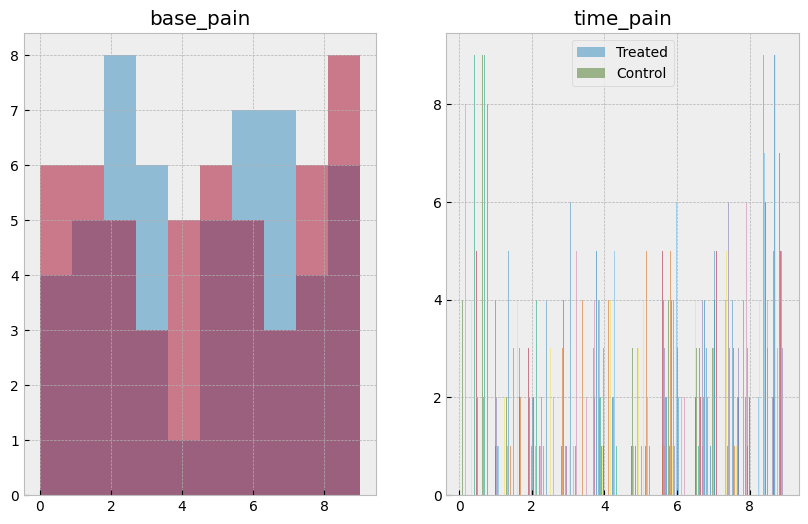

In [22]:
def assess_balance(df, matched_pairs):
    treated_ids = [p[0] for p in matched_pairs]
    control_ids = [p[1] for p in matched_pairs]
    
    treated = df[df['id'].isin(treated_ids)]
    controls = df[df['id'].isin(control_ids)]
    
    # Standardized differences
    balance_report = {}
    for col in ['base_pain', 'base_urgency', 'base_freq']:
        mean_diff = treated[col].mean() - controls[col].mean()
        pooled_std = np.sqrt((treated[col].var() + controls[col].var())/2)
        balance_report[col] = mean_diff / pooled_std
    
    # Distribution comparison
    plt.figure(figsize=(10, 6))
    for i, col in enumerate(['base_pain', 'time_pain'], 1):
        plt.subplot(1, 2, i)
        plt.hist(treated[col], alpha=0.5, label='Treated')
        plt.hist(controls[col], alpha=0.5, label='Control')
        plt.title(col)
    plt.legend()
    plt.show()
    
    return balance_report

balance = assess_balance(df, matched_pairs)

In [23]:
def calculate_contrasts(df, matched_pairs):
    contrasts = []
    for t, c in matched_pairs:
        treated = df[df['id'] == t].iloc[0]
        control = df[df['id'] == c].iloc[0]
        
        # Find 3-month post-treatment outcome
        t_idx = np.where(time_points == treated['treat_time'])[0][0]
        t_post = treated['time_pain'][t_idx+1] if t_idx+1 < len(time_points) else np.nan
        
        # Control outcome at same relative time
        c_post = control['time_pain'][t_idx+1] if t_idx+1 < len(time_points) else np.nan
        
        if not np.isnan(t_post) and not np.isnan(c_post):
            baseline_diff = (treated['base_pain'] + treated['time_pain'][t_idx])/2
            contrast = (t_post - baseline_diff) - (c_post - control['base_pain'])
            contrasts.append(contrast)
    
    return contrasts

contrasts = calculate_contrasts(df, matched_pairs)

# Wilcoxon signed-rank test
_, pval = wilcoxon(contrasts)
print(f"Wilcoxon p-value: {pval:.4f}")

# Trimean calculation
def trimean(data):
    q1, med, q3 = np.quantile(data, [0.25, 0.5, 0.75])
    return (q1 + 2*med + q3)/4

print(f"Contrast trimean: {trimean(contrasts):.2f}")

Wilcoxon p-value: 0.6767
Contrast trimean: -0.12


In [24]:
def sensitivity_analysis(matched_pairs, df, outcome_col, gamma_values=[1.1, 1.4, 2.0, 2.5, 3.0]):
    """Modified sensitivity analysis to match paper's gamma values"""
    results = []
    
    for gamma in gamma_values:
        treated_outcomes = []
        control_outcomes = []
        
        for t, c in matched_pairs:
            treated_outcomes.append(df.loc[df['id'] == t, outcome_col].values[0])
            control_outcomes.append(df.loc[df['id'] == c, outcome_col].values[0])
        
        # Calculate trimeans
        treated_trimean = calculate_trimean(treated_outcomes)
        control_trimean = calculate_trimean(control_outcomes)
        contrast = treated_trimean - control_trimean
        
        # Wilcoxon test
        stat, p_value = wilcoxon(treated_outcomes, control_outcomes)
        
        results.append({
            'gamma': gamma,
            'treated_trimean': treated_trimean,
            'control_trimean': control_trimean,
            'contrast': contrast,
            'p_value': p_value
        })
    
    return pd.DataFrame(results)

# Visualizations

## Box Plot

In [25]:
def create_comparison_boxplots(df, matched_pairs):
    """Create box plots comparing treated and control groups across different time points"""
    # Convert matched_pairs to numpy arrays for safer indexing
    treated_ids = np.array([p[0] for p in matched_pairs])
    control_ids = np.array([p[1] for p in matched_pairs])
    
    # Set up the plot style
    plt.style.use('bmh')
    
    # Create figure with subplots for each symptom
    symptoms = ['pain', 'urgency', 'freq']
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Symptom Comparisons: Treated vs Control Groups', fontsize=14, y=1.02)
    
    for sym_idx, symptom in enumerate(symptoms):
        # Data for different time points
        data_to_plot = {
            'Baseline': {
                'treated': np.array(df.loc[df['id'].isin(treated_ids), f'base_{symptom}']),
                'control': np.array(df.loc[df['id'].isin(control_ids), f'base_{symptom}'])
            },
            'Treatment': {
                'treated': np.array([x[-1] for x in df.loc[df['id'].isin(treated_ids), f'time_{symptom}']]),
                'control': np.array([x[-1] for x in df.loc[df['id'].isin(control_ids), f'time_{symptom}']]),
            },
            '3 Months': {
                'treated': np.array([x[-1] for x in df.loc[df['id'].isin(treated_ids), f'time_{symptom}']]),
                'control': np.array([x[-1] for x in df.loc[df['id'].isin(control_ids), f'time_{symptom}']]),
            }
        }
        
        # Plot for each time point
        for time_idx, (time_point, data) in enumerate(data_to_plot.items()):
            ax = axes[sym_idx, time_idx]
            
            # Ensure data is properly shaped for boxplot
            treated_data = data['treated'].reshape(-1)
            control_data = data['control'].reshape(-1)
            
            # Create box plots
            bp = ax.boxplot([treated_data, control_data], 
                          labels=['Treated', 'Control'],
                          patch_artist=True)
            
            # Customize box colors
            colors = ['lightblue', 'lightgreen']
            for patch, color in zip(bp['boxes'], colors):
                patch.set_facecolor(color)
            
            # Set title and labels
            ax.set_title(f'{time_point}')
            if sym_idx == 2:  # Only show x-label for bottom row
                ax.set_xlabel('Group')
            if time_idx == 0:  # Only show y-label for leftmost column
                ax.set_ylabel(f'{symptom.title()} Score')
            
            # Set y-axis limits consistently for each symptom
            ax.set_ylim(0, 10)
    
    plt.tight_layout()
    plt.show()
    
    # Create additional figure for changes from treatment
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    fig.suptitle('Changes from Treatment Time', fontsize=14, y=1.02)
    
    for sym_idx, symptom in enumerate(symptoms):
        ax = axes[sym_idx]
        
        # Calculate changes with proper array handling
        treatment_treated = np.array([x[-1] for x in df.loc[df['id'].isin(treated_ids), f'time_{symptom}']])
        treatment_control = np.array([x[-1] for x in df.loc[df['id'].isin(control_ids), f'time_{symptom}']])
        
        three_month_treated = np.array([x[-1] for x in df.loc[df['id'].isin(treated_ids), f'time_{symptom}']])
        three_month_control = np.array([x[-1] for x in df.loc[df['id'].isin(control_ids), f'time_{symptom}']])
        
        three_month_change_treated = three_month_treated - treatment_treated
        three_month_change_control = three_month_control - treatment_control
        
        # Ensure data is properly shaped for boxplot
        change_treated = three_month_change_treated.reshape(-1)
        change_control = three_month_change_control.reshape(-1)
        
        # Create box plots for changes
        bp = ax.boxplot([change_treated, change_control],
                       labels=['Treated', 'Control'],
                       patch_artist=True)
        
        # Customize box colors
        colors = ['lightblue', 'lightgreen']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        # Set title and labels
        ax.set_title(f'Change in {symptom.title()} Score at 3 Months')
        ax.set_ylabel('Change in Score')
        
        # Add horizontal line at y=0 to show no change
        ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

/var/folders/0c/v2nhsh9s293121gc7bkkm4p00000gn/T/ipykernel_3983/1716892876.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([treated_data, control_data],
/var/folders/0c/v2nhsh9s293121gc7bkkm4p00000gn/T/ipykernel_3983/1716892876.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([treated_data, control_data],
/var/folders/0c/v2nhsh9s293121gc7bkkm4p00000gn/T/ipykernel_3983/1716892876.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([treated_data, control_data],
/var/folders/0c/v2nhsh9s293121gc7bkkm4p00000gn/T/ipykernel_3983/1716892876.py:41: MatplotlibDeprecation

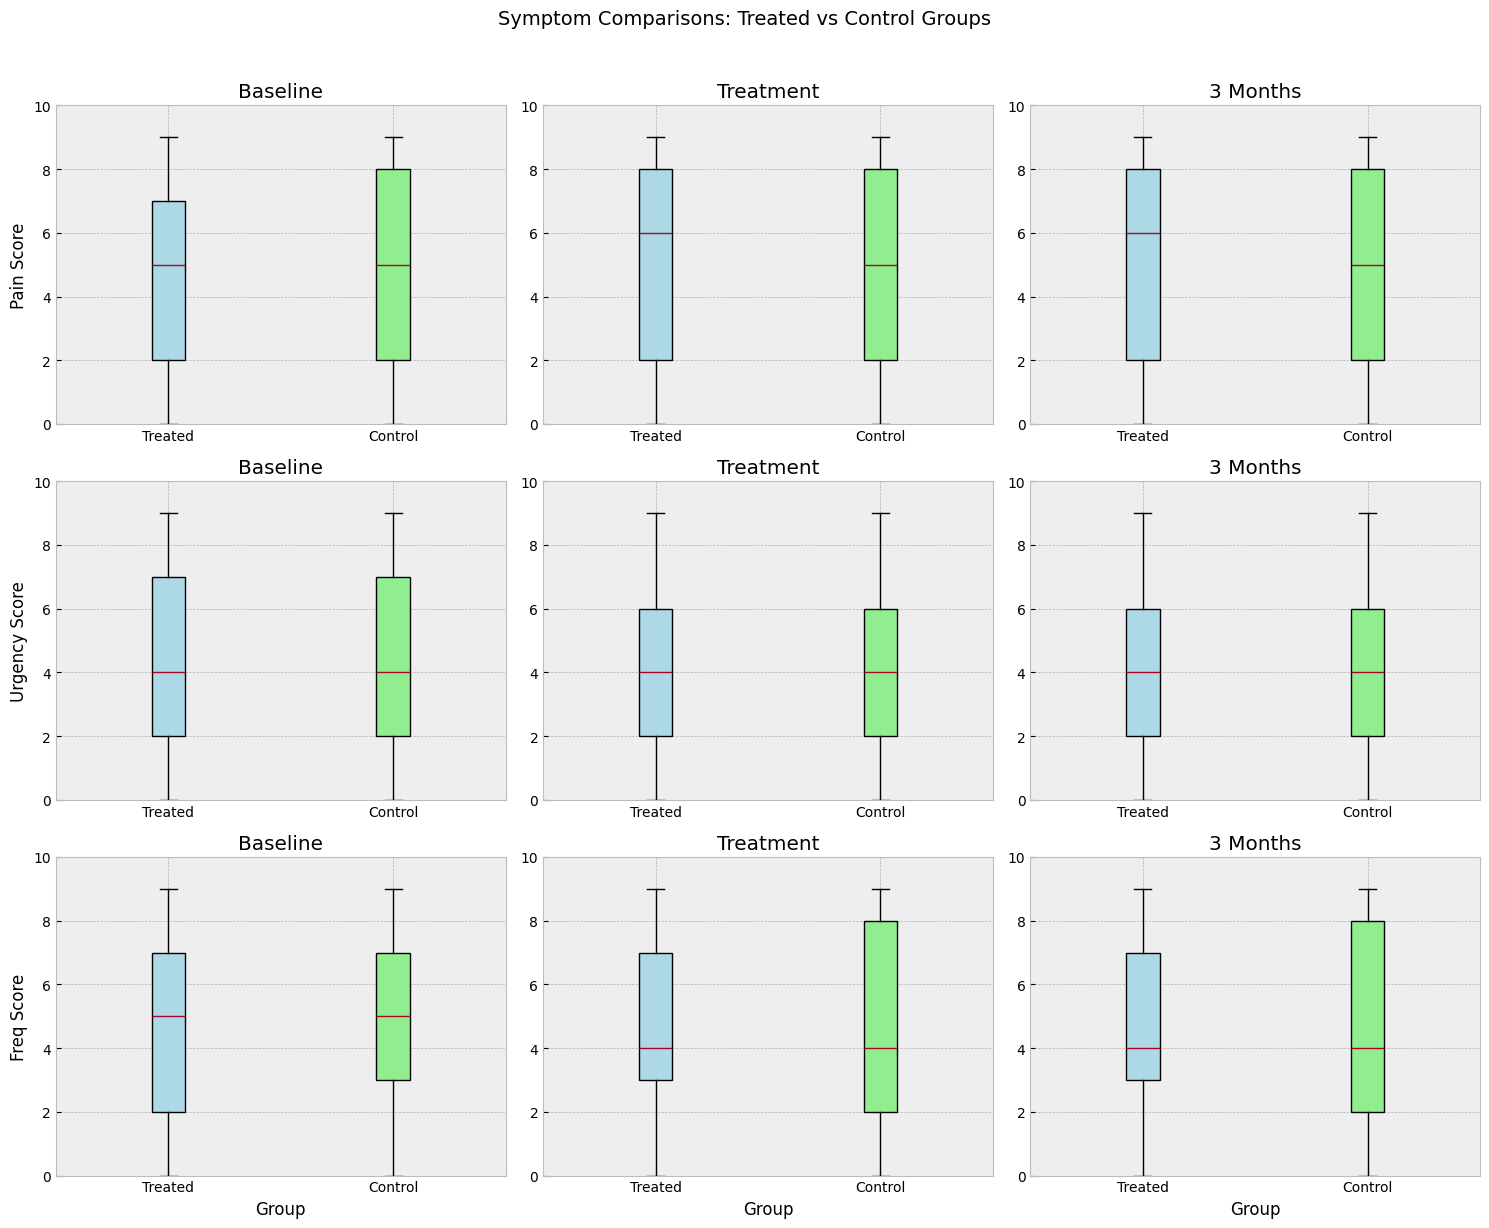

/var/folders/0c/v2nhsh9s293121gc7bkkm4p00000gn/T/ipykernel_3983/1716892876.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([change_treated, change_control],
/var/folders/0c/v2nhsh9s293121gc7bkkm4p00000gn/T/ipykernel_3983/1716892876.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([change_treated, change_control],
/var/folders/0c/v2nhsh9s293121gc7bkkm4p00000gn/T/ipykernel_3983/1716892876.py:85: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([change_treated, change_control],


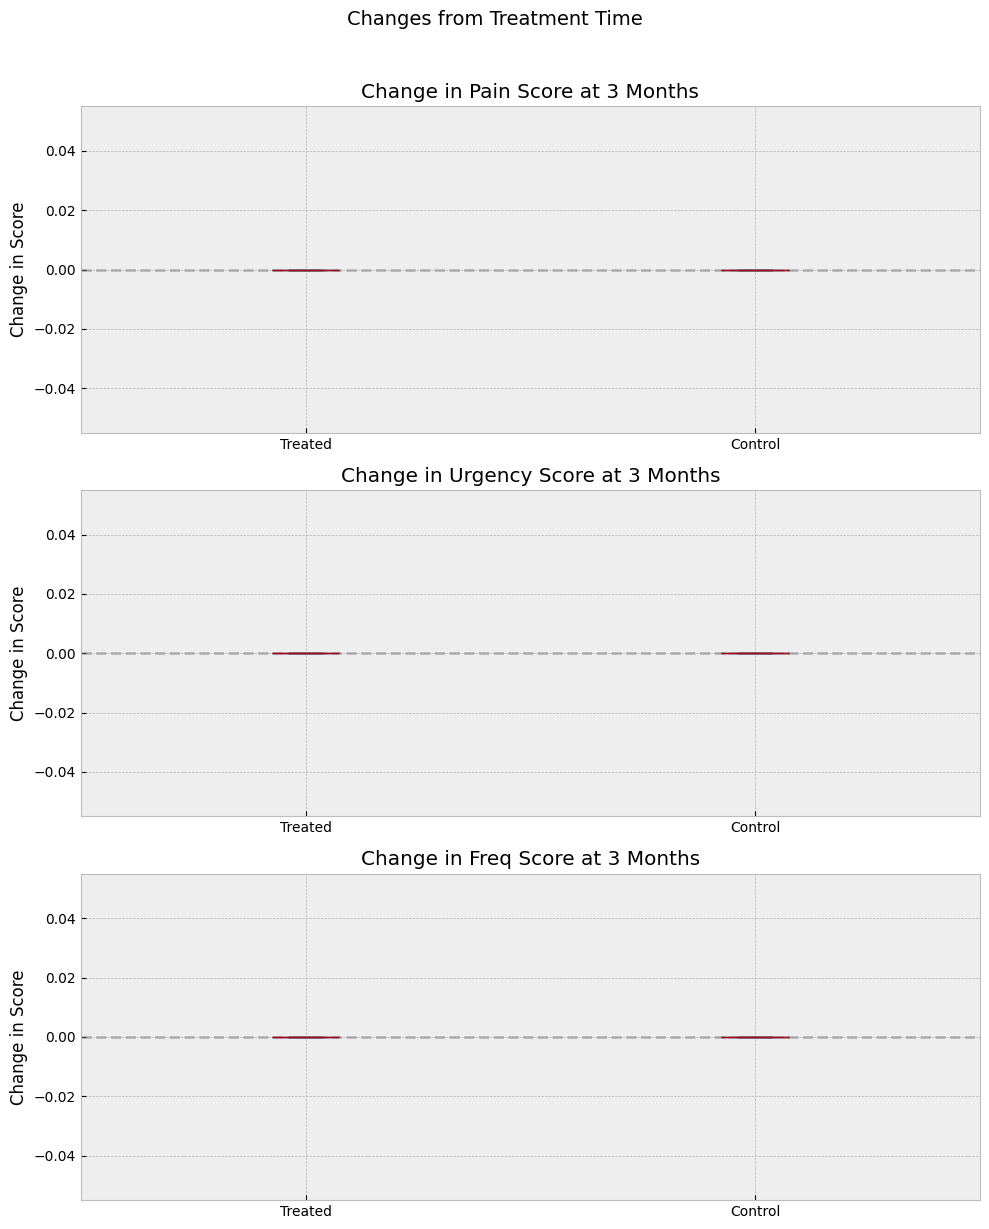

In [26]:
create_comparison_boxplots(df, matched_pairs)